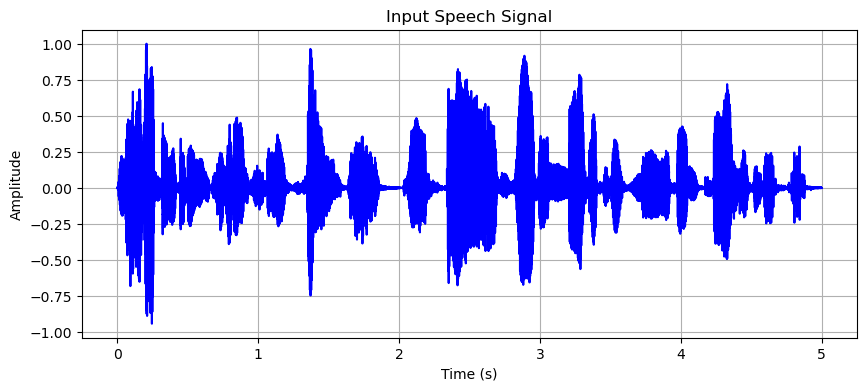

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile


def normalize_and_plot(file_path):

    # take input 
    sample_rate, audio_data = wavfile.read(file_path)
    
    # normalize by using the maximum 
    # rms normalization has the risk of clipping, so we choose max normalization 

    # TODO: do this per window's max? 
    normalized_data = audio_data / np.max(np.abs(audio_data))
    time = np.arange(0, len(audio_data)) / sample_rate

    # plot the normalized speech signal
    plt.figure(figsize=(10, 4))
    plt.plot(time, normalized_data, color='b')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Input Speech Signal')
    plt.grid(True)
    plt.show()

    return normalized_data, sample_rate

normalized_data, sample_rate = input_normalize_plot("C:\\Users\\ssshr\\Downloads\\LJSpeech-1.1\\wavs\\LJ001-0083.wav")

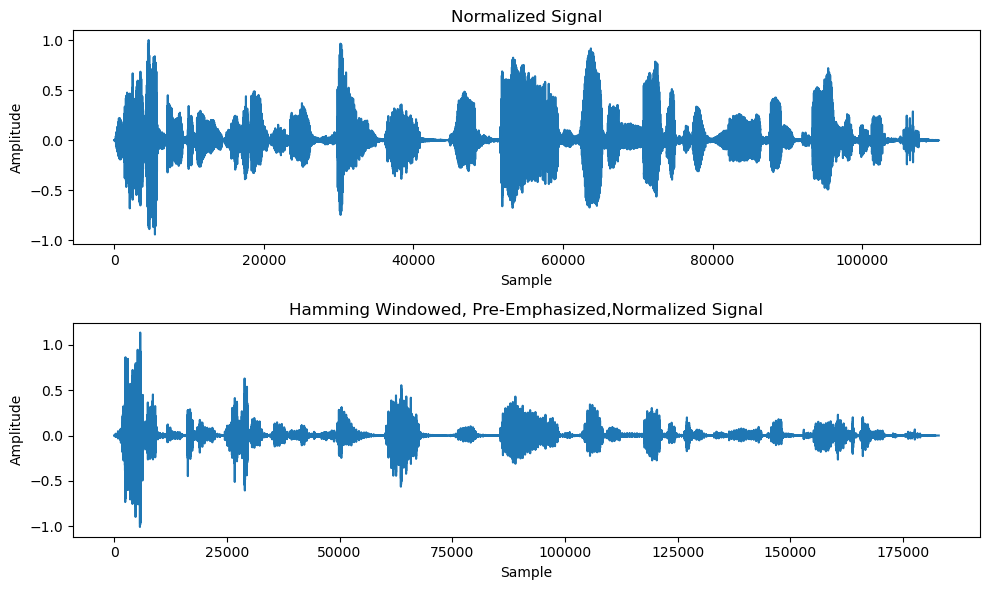

In [8]:
import librosa

# split the speech into windows for short time analysis 
def split_window_preemphasize(normalized_data, sample_rate, window_size_ms, overlap_ms, pre_emph_coef = 0.9, plot=False):
   
    # calculate samples
    window_size_samples = int(window_size_ms * sample_rate / 1000)
    overlap_size_samples = int(overlap_ms * sample_rate / 1000)
    window_step_samples = window_size_samples - overlap_size_samples

    # split into short windows 
    split_signal = [] 
    start = 0
    while start + window_size_samples <= len(normalized_data):
        end = start + window_size_samples
        split_signal.append(librosa.effects.preemphasis(normalized_data[start:end], coef=pre_emph_coef))
        start += window_step_samples
    
    # apply Hamming window to each short window 
    hamming_window = np.hamming(window_size_samples)
    hamming_short_windows = [short_window * hamming_window for short_window in split_signal]

    # concatenate all the windows to one signal that has been Hamming windowed
    hamming_windowed_signal = np.concatenate(hamming_short_windows)

    # TODO: plot vertical lines to indicate short window boundaries 
    if plot: 
        # plot the normal and the Hamming windowed signal 
        plt.figure(figsize=(10, 6))

        # Original normalized signal
        plt.subplot(2, 1, 1)
        plt.plot(normalized_data)
        plt.title('Normalized Signal')
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')


        # Hamming windowed signal
        plt.subplot(2, 1, 2)
        plt.plot(hamming_windowed_signal)
        plt.title('Hamming Windowed, Pre-Emphasized,Normalized Signal')
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
        plt.tight_layout()

    return hamming_short_windows, hamming_windowed_signal


hamming_short_windows, hamming_window_signal = split_window_preemphasize(normalized_data, sample_rate, 25, 10, plot=True)

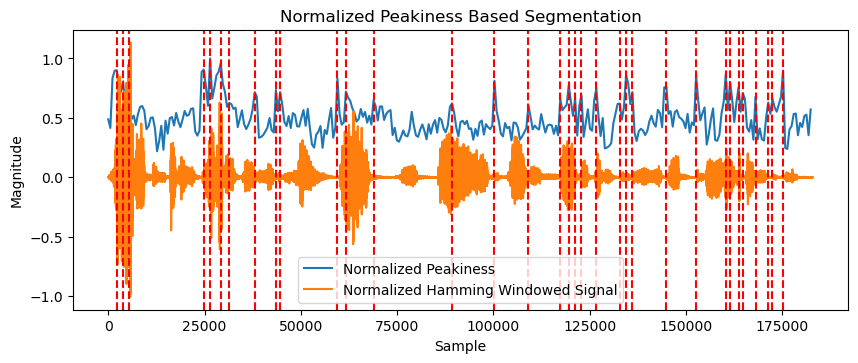

In [17]:

from scipy.signal import find_peaks
def peakiness_segmentation(hamming_short_windows, peakiness_threshold=0.6):
    rms_peak_heights = []
    max_peak_heights = []

    for window in hamming_short_windows:
        # calculate autocrrelation 
        autocorr = np.correlate(window, window, mode='full')
        autocorr = autocorr[len(autocorr)//2:]

        # find peaks 
        peaks, _ = find_peaks(autocorr)

        if len(peaks) > 0:
            peak_heights = autocorr[peaks]

            rms_peak_height = np.sqrt(np.mean(np.square(peak_heights)))
            max_peak_height = np.max(peak_heights)

            rms_peak_heights.append(rms_peak_height)
            max_peak_heights.append(max_peak_height)

    # calculate quality of peak 
    peakiness = [max_peak / rms_peak for max_peak, rms_peak in zip(max_peak_heights, rms_peak_heights)]
    normalized_peakiness = [value / max(peakiness) for value in peakiness]

    
    plt.figure(figsize=(10, 8))

    x = [i * len(hamming_short_windows[0]) for i in range(len(hamming_short_windows))]
    plt.subplot(2, 1, 1)
    plt.plot(x, normalized_peakiness, label='Normalized Peakiness')
    plt.plot(np.concatenate(hamming_short_windows), label='Normalized Hamming Windowed Signal')
    plt.title('Normalized Peakiness Based Segmentation')
    plt.xlabel('Sample')
    plt.ylabel('Magnitude')
    plt.legend()

    # observe changes in peakiness values, apply threshold, and draw boundaries there 
    peakiness_segment_boundaries_samples = [] 
    peakiness_indices, _ = find_peaks(normalized_peakiness)
    for x in peakiness_indices: 
        if normalized_peakiness[x] > peakiness_threshold:
            plt.axvline(x=x * len(hamming_short_windows[0]), color='r', linestyle='--') 
            peakiness_segment_boundaries_samples.append(x * len(hamming_short_windows[0]))

    # return the samples where boundaries were identified 
    return peakiness_segment_boundaries_samples
peakiness_segmentation(hamming_short_windows, plot=True)

([1102,
  3306,
  6612,
  20387,
  22591,
  23142,
  24795,
  25897,
  26448,
  29754,
  30305,
  38570,
  39121,
  39672,
  40774,
  44631,
  49590,
  59508,
  73834,
  79344,
  79895,
  80446,
  99180,
  110200,
  120118,
  121220,
  122322,
  125628,
  130587,
  131138,
  132240,
  132791,
  142709,
  143260,
  145464,
  148770,
  149321,
  151525,
  156484,
  163647,
  165851,
  172463,
  173014,
  177973,
  179075,
  179626],
 [[8813.284869584428, 7063.223406146318, 4672.676123607516],
  [0, 0, 8780.336067515167],
  [684.3132056455956, 4291.347119254141, 7431.328279294309],
  [8524.609697710292, 3267.102699513547, 4908.773549819994],
  [350.33925114271216, 3543.963737063309, 8686.969101496368],
  [8485.958918413626, 327.4165050479112, 3612.8239227484537],
  [0, 0, 0.0],
  [0, 0, 7927.811771560153],
  [9167.14148531845, 7766.19817856091, 6293.32467339235],
  [0, 0, 0.0],
  [7708.233164227333, 4572.927476898925, 1848.6148865629052],
  [8293.364977536858, 5528.708032739241, 1677.4555

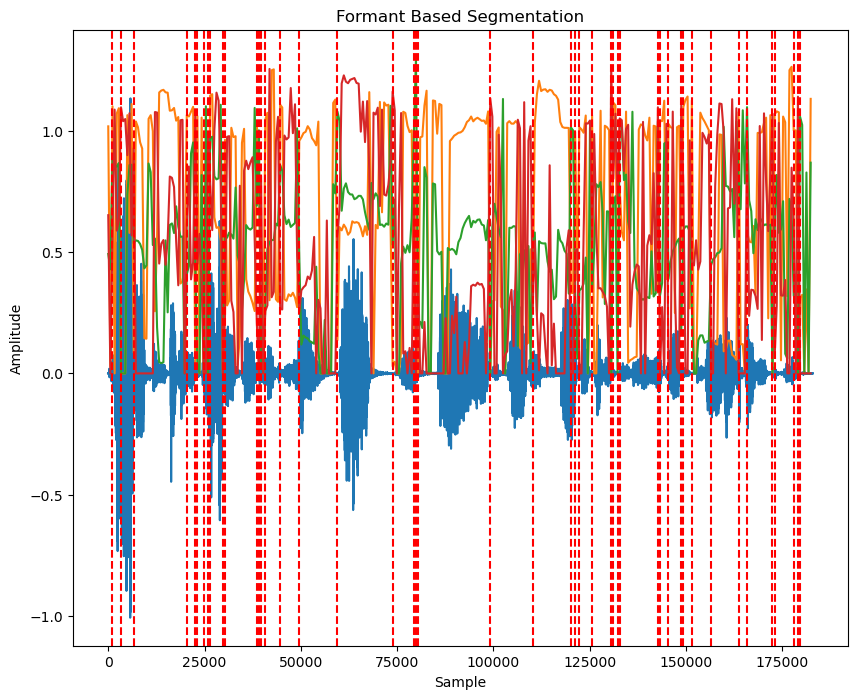

In [48]:
from scipy.signal import lfilter

def formant_segmentation(hamming_short_windows, formant_diff_threshold=0.2): 

    # use LPC to calculate formants 
    order = 8 

    formant_frequencies = [[], [], []] 

    for window in hamming_short_windows:
        lpc_coefficients = librosa.lpc(window, order=order)
        lpc_roots = np.roots(lpc_coefficients)
    
        # keep only one per conjugate pair 
        positive_imag_roots = lpc_roots[lpc_roots.imag > 0]
        # find the angle and convert rad/s to Hz 
        formants = (np.angle(positive_imag_roots) * sample_rate / (2 * np.pi)).tolist()[:3]
        bandwidths = [(-0.5 * sample_rate / (2 * np.pi) * np.log(np.abs(root))) for root in lpc_roots]
       
        # formants are at least 90Hz, and bandwidth is less than 400Hz
        for i in range(len(formants)): 
            if formants[i] >= 90 and bandwidths[i] < 400:
                formant_frequencies[i].append(formants[i])
            else:
                formant_frequencies[i].append(0)
    
    if (len(formant_frequencies[2]) < len(hamming_short_windows)):
        formant_frequencies[2] = np.pad(formant_frequencies[2], (0, len(hamming_short_windows) - len(formant_frequencies[2])), mode='constant', constant_values=0)

    x = [i * len(hamming_short_windows[0]) for i in range(len(hamming_short_windows))]
    
    plt.figure(figsize=(10, 8))
    plt.title('Formant Based Segmentation')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')

    plt.plot(np.concatenate(hamming_short_windows))
    plt.plot(x, [ i / 8000 for i in formant_frequencies[0]])
    plt.plot(x, [ i / 8000 for i in formant_frequencies[1]])
    plt.plot(x, [ i / 8000 for i in formant_frequencies[2]])
    formant_segment_boundaries_samples = [] 
    formants_at_boundaries = [] 
    for i in range(1, len(formant_frequencies[0])):
        diff_1 = abs(formant_frequencies[0][i] - formant_frequencies[0][i-1]) / 8000
        diff_2 = abs(formant_frequencies[1][i] - formant_frequencies[1][i-1]) / 8000
        diff_3 = abs(formant_frequencies[2][i] - formant_frequencies[2][i-1]) / 8000
        if diff_1 > formant_diff_threshold and diff_2 > formant_diff_threshold and diff_3 > formant_diff_threshold:
            plt.axvline(x=i * len(hamming_short_windows[0]), color='r', linestyle='--')
            formant_segment_boundaries_samples.append(i * len(hamming_short_windows[0]))
            formants_at_boundaries.append([formant_frequencies[0][i], formant_frequencies[1][i], formant_frequencies[2][i]])
    return formant_segment_boundaries_samples, formants_at_boundaries

formant_segment_boundaries_samples, formants_at_boundaries = formant_segmentation(hamming_short_windows)

0.0002982119024753385
0.0035917595567875327
0.1000379823711272
0.3716978889585371
0.05838742078620446
0.19948306637858282
0.19356340896848123
0.11789898687072675
0.3539597039601825
0.055152662756405735
0.8016169005726343
0.13221760800348253
0.01509500216445282
0.0059123986960915136
0.02076746776802158
0.027866862100933944
0.02377860724859696
0.0007692597448105431
5.531107603953898e-05
1.1066678730024663e-06
0.003315591496060343
0.0007579992258991463
0.0020473793649264773
0.0007198984139577425
4.5002466815045956e-05
7.190906752196566e-07
5.2366108426212215e-05
8.402466774722169e-05
0.07511585404201744
0.024956360302824748
0.06600466581364053
0.030567167097245405
0.0005147808629038316
0.014384010325401042
0.00700126394052073
0.006716151395923981
0.0016283689610377848
0.00019418466229066678
7.697649192384397e-06
0.0016073657851069312
0.0005828447336555455
2.2179579816258312e-05
1.8588124150169917e-05
0.0011532194466302185
0.012302079863547194
0.008273205510102676
0.06726027253124649
0.088

[1653,
 2204,
 2755,
 3306,
 3857,
 4408,
 4959,
 5510,
 6061,
 6612,
 7163,
 8265,
 8816,
 9367,
 15979,
 16530,
 17081,
 17632,
 18734,
 24795,
 25897,
 26448,
 26999,
 27550,
 28101,
 28652,
 29203,
 29754,
 35264,
 49590,
 60059,
 60610,
 61161,
 61712,
 62263,
 62814,
 63365,
 63916,
 64467,
 65018,
 65569,
 66120,
 66671,
 67222,
 67773,
 85956,
 117363,
 117914,
 120669,
 121220,
 126730,
 127281,
 127832,
 159790,
 160341,
 161443,
 163647,
 164198,
 165851,
 166402,
 166953,
 167504]

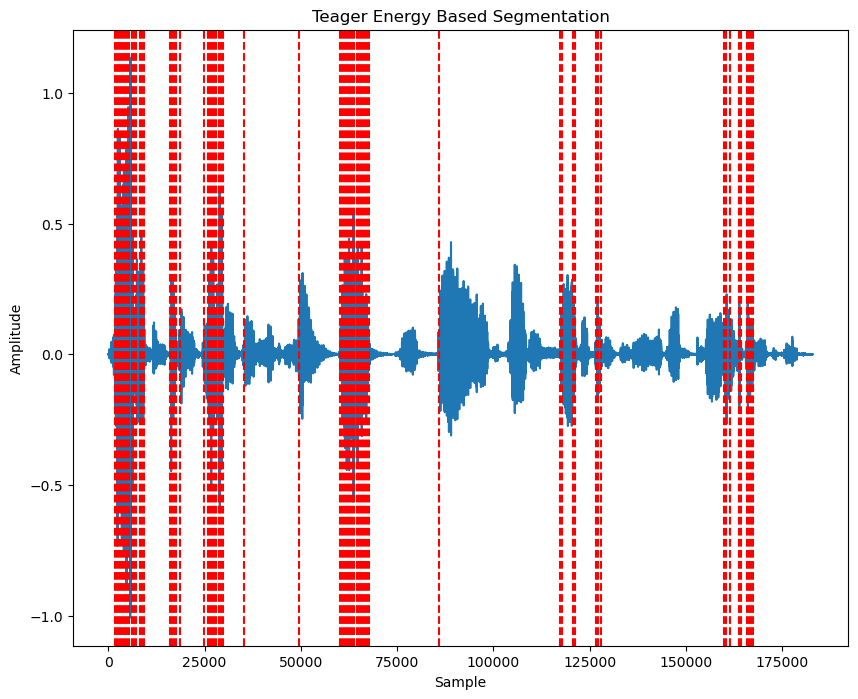

In [59]:
def teager_energy_segmentation(hamming_short_windows, energy_threshold=0.009): 
    teager_energy = []

    # compute Teager energy 
    for window in hamming_short_windows:
        energy = 0
        for i in range(0, len(window)):
            if (i == 0):
                energy += window[i] ** 2 - window[i + 1]
            elif (i == len(window) - 1):
                energy += window[i] **  2 - window[i - 1]
            else: 
                energy += window[i]**2 - (window[i + 1] * window[i - 1])
        teager_energy.append(energy)
    
    teager_energy = [value / max(teager_energy) for value in teager_energy]
    energy_segment_boundaries_samples = [] 
    plt.figure(figsize=(10, 8))
    plt.title('Teager Energy Based Segmentation')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')

    plt.plot(np.concatenate(hamming_short_windows))
  

    for i in range(1, len(teager_energy)):
        diff = abs(teager_energy[i] - teager_energy[i-1])
        if diff > energy_threshold:
            plt.axvline(x=i * len(hamming_short_windows[0]), color='r', linestyle='--') 
            energy_segment_boundaries_samples.append(i * len(hamming_short_windows[0]))
    return energy_segment_boundaries_samples
teager_energy_segmentation(hamming_short_windows)

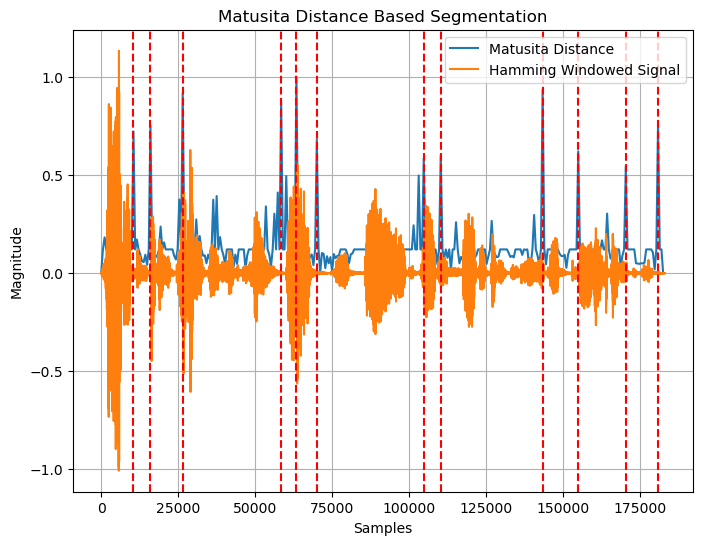

[10469,
 15979,
 26448,
 58406,
 63365,
 69977,
 104690,
 110200,
 143260,
 154831,
 170259,
 180728]

In [74]:
from scipy.integrate import simpson
from scipy.stats import chi2

def matusita_distance(pdf1, pdf2, x):
    integral = simpson(np.sqrt(pdf1 * pdf2), x=x)
    return 1 - integral 

def matusita_dist_segmentation(hamming_short_windows, matusita_threshold=0.5):
    # https://www.csd.uoc.gr/~tziritas/papers/SpeechMusicEusipco.pdf 
    pdfs = [] 
    dfs = [] 
    for window in hamming_short_windows:
        # fit chi-squared distribution 
        df, loc, scale = chi2.fit(window)

        # save the pdf 
        x = np.linspace(chi2.ppf(0.001, df), chi2.ppf(0.999, df), 1000)
        pdf_estimate = chi2.pdf(x, df, loc, scale)
        pdfs.append(pdf_estimate)
        dfs.append(df)
    
    # compute matusita distances between consecutive windows 
    matusita_distances = []
    for i in range(1, len(hamming_short_windows) - 1):
        datavalues = np.linspace(chi2.ppf(0.001, dfs[i]), chi2.ppf(0.999, dfs[i]), 1000)
        matusita_distances.append(matusita_distance(pdfs[i - 1], pdfs[i + 1], datavalues))
    
    # padding at the end and beginning 
    matusita_distances.insert(0, 0)
    matusita_distances.append(0)

    norm_matusita_distances = [abs(i / abs(max(matusita_distances, key=abs))) for i in matusita_distances]

    x = [i * len(hamming_short_windows[0]) for i in range(len(hamming_short_windows))]
    plt.figure(figsize=(8, 6))
    plt.plot(x, norm_matusita_distances, label="Matusita Distance")
    plt.plot(np.concatenate(hamming_short_windows), label="Hamming Windowed Signal")
    plt.legend()
    plt.xlabel('Samples')
    plt.ylabel('Magnitude')
    plt.title('Matusita Distance Based Segmentation')
    
    # threshold 
    indices_above_threshold = [] 
    for i in range(len(norm_matusita_distances)):
        if norm_matusita_distances[i] > matusita_threshold:
            indices_above_threshold.append(i) 


    matusita_distance_segment_boundaries_samples = []
    # TODO: find the time instant where two successive frames are located before and after this instant have the maximum distance 
    for i in indices_above_threshold:
        plt.axvline(x=i * len(hamming_short_windows[0]), color='r', linestyle='--')
        matusita_distance_segment_boundaries_samples.append(i * len(hamming_short_windows[0]))
    plt.grid(True)
    plt.show()

    return matusita_distance_segment_boundaries_samples



matusita_dist_segmentation(hamming_short_windows)


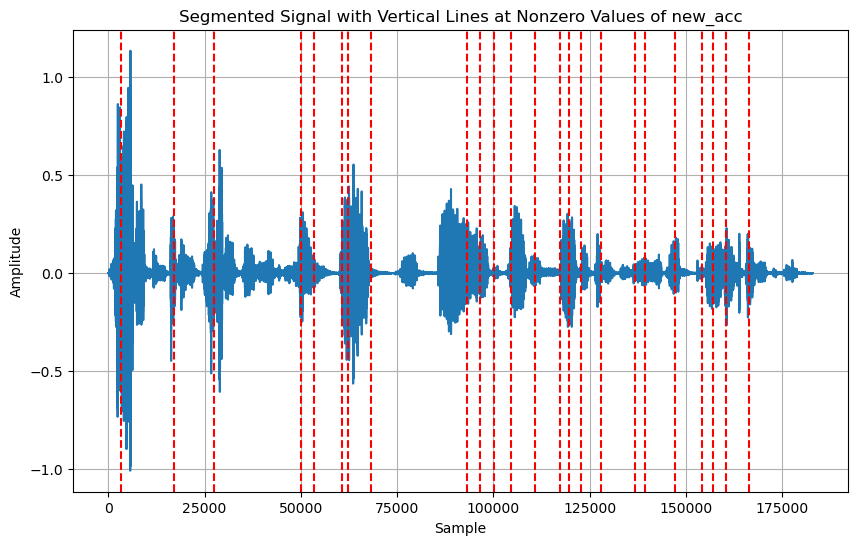

In [83]:
def fitting_proc_segmentation(hamming_short_windows, a=1, b=0.01, c=2):  

    # calculate J  
    j_vals = []
    for seg in range(len(hamming_short_windows)):
        # compute  J function 
        j = 0
        for count in range(seg - a, seg):
            j += hamming_short_windows[seg][count]
        for count in range(seg + 1, seg + a + 1):
            j -= hamming_short_windows[seg][count]
        j_vals.append(j / a)

    # detect peaks in J according to threshold b 
    s = []
    for j in j_vals:
        if j >= b:
            s.append(1)
        else:
            s.append(0)

    p = 0
    q = 3
    acc = [0] * len(s) 
    for n in range(a, len(hamming_short_windows) - a - c):
        # compute f[n] for each n in the range (p, q)
        f_min = np.Inf
        min_index = 0  
    
        for v in range(n, n + c + 1):
            f = 0 
            for m in range(n, n + c + 1):
                for i in range(1, 2):
                    f += s[m * i] * np.abs(v - m)
            if (f < f_min):
                f_min = f 
                min_index = v
        nwin = min_index 
    
        acc[nwin] += 1 
        
    new_acc = [1 if i > 2 else 0 for i in acc]
    np.count_nonzero(new_acc)

    # Plot segmented_signal
    plt.figure(figsize=(10, 6))
    plt.plot(np.concatenate(hamming_short_windows))

    # Find indices of nonzero values in new_acc and multiply by 220
    fitting_proc_segment_boundaries_samples = np.nonzero(new_acc)[0] * len(hamming_short_windows[0])

    # Plot vertical lines at the calculated indices
    for index in fitting_proc_segment_boundaries_samples:
        plt.axvline(x=index, color='r', linestyle='--')


    plt.title('Fitting Process Based Segmentation')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()
    return fitting_proc_segment_boundaries_samples
fitting_proc_segmentation(hamming_short_windows)